# Load audio data to array numpy

In [1]:
import os
import librosa

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_files = {}

for g in genres:
  audio_files[g] = []

for g in genres:
  for audio in os.listdir(f'./genres/{g}'):
    # Audio loaded as [ndarray, float]
    audio_files[g].append(librosa.core.load(f'./genres/{g}/{audio}'))

# Preprocessing

In [2]:
import numpy as np

mel_specs = []

for g in genres:

  for audio in audio_files[g]:

    y = audio[0]
    sr = audio[1]

    # Generate log power spectrogram
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.median) # max
    if spect.shape[1] != 600:
      # spect.resize(128,660, refcheck=False)
      spect = spect[:128,:600]
      # print(spect.shape)
      spect.reshape(128,600)


    mel_specs.append(spect)
        
X = np.array(mel_specs)

# See images generated

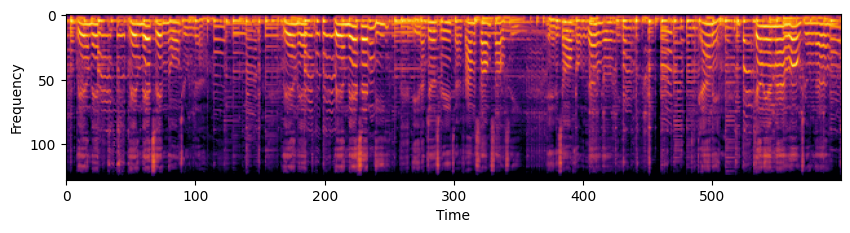

In [3]:
import matplotlib.pyplot as plt

# Specify the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Add x and y axis titles
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')

# Display the image
ax.imshow(mel_specs[0], cmap='inferno')

# Show the plot
plt.show()

# Train test split

### Import

In [4]:
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2023-08-09 15:37:27.151565: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 15:37:27.184440: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 15:37:27.184915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 15:37:27.819243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Create y 

In [5]:
# TODO: Delete duplicated jazz sample (54)
y_cnn = []
for i in range(len(genres)):
  y_cnn += 100*[i] # On a 100 images pour chaque genre

# One-hot encodage
y_cnn = to_categorical(np.array(y_cnn))
# y_cnn = np.array(y_cnn)

### Train test split

In [6]:
x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn, test_size=0.2)

In [7]:
# Working
x_cnn_train /= np.min(x_cnn_train)
x_cnn_test /= np.min(x_cnn_train)

x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 128, 600, 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 128, 600, 1)

# Model

### Neural networks layers

In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(128, 600, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

# model = tf.keras.models.Sequential()

# model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=(128,600,1)))

# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Conv2D(64, 
#                  kernel_size=(3, 3), 
#                  activation='relu'))

# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Dropout(0.3))

# model.add(tf.keras.layers.Conv2D(32, 
#                  kernel_size=(3, 3), 
#                  activation='relu'))

# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(32, activation='relu'))

# model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 598, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 299, 16)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 301392)            0         
                                                                 
 dense (Dense)               (None, 64)                19289152  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 19289962 (73.59 MB)
Trainable params: 19289962 (73.59 MB)
Non-trainable params: 0 (0.00 Byte)
______________

2023-08-09 15:37:28.709085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 15:37:28.727445: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Compile

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1) # learning_rate=0.0001
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
loss_function = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    loss=loss_function, #"categorical_crossentropy"
    optimizer=optimizer,
    metrics=["accuracy"]
)

### Fit

In [10]:
history = model.fit(x_cnn_train,
                    y_cnn_train,
                    epochs=10,
                    validation_data = (x_cnn_test,y_cnn_test))

Epoch 1/10


25/25 [==============================] - 11s 440ms/step - loss: 279.3368 - accuracy: 0.1013 - val_loss: 48917.6641 - val_accuracy: 0.1600
Epoch 2/10
25/25 [==============================] - 11s 432ms/step - loss: 2.3323 - accuracy: 0.0850 - val_loss: 51379.5469 - val_accuracy: 0.1100
Epoch 3/10
25/25 [==============================] - 11s 430ms/step - loss: 2.3021 - accuracy: 0.1100 - val_loss: 53015.1914 - val_accuracy: 0.1050
Epoch 4/10
25/25 [==============================] - 11s 432ms/step - loss: 2.3041 - accuracy: 0.0962 - val_loss: 53147.5547 - val_accuracy: 0.1100
Epoch 5/10
25/25 [==============================] - 11s 430ms/step - loss: 2.3070 - accuracy: 0.0962 - val_loss: 53157.5234 - val_accuracy: 0.1100
Epoch 6/10
25/25 [==============================] - 11s 431ms/step - loss: 2.3033 - accuracy: 0.0850 - val_loss: 53158.2148 - val_accuracy: 0.1050
Epoch 7/10
25/25 [==============================] - 11s 433ms/step - loss: 2.3057 - accuracy: 0.1238 - val_loss: 53157.7344 - v

### Save

In [11]:
# model.save("my_model_cnn_clean_v1.keras")

# Metrics

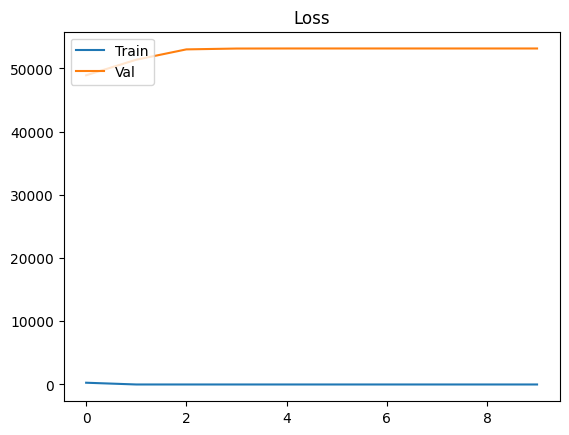

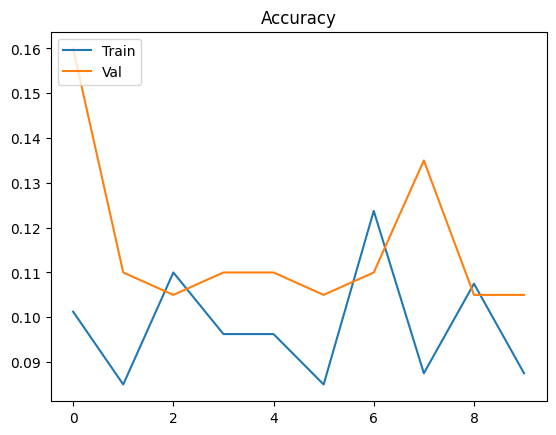

In [12]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

# Predict

### Preprocessing

In [13]:
# audio = librosa.core.load(f'./genres/blues/blues.00000.wav')
# audio = librosa.core.load(f'./genres/blues/blues.00049.wav')
audio = librosa.core.load(f'./genres/disco/disco.00090.wav')
# audio = librosa.core.load(f'./genres/jazz/jazz.00097.wav')
y = audio[0]
sr = audio[1]

# Generate log power spectrogram
S = np.abs(librosa.stft(y))
spect = librosa.power_to_db(S**2, ref=np.median)

# Slice to have same shapes for all
spect = spect[:1000,:1220]

# Compress for the model
new_shape = (100,122)
block_height = spect.shape[0] // new_shape[0]
block_width = spect.shape[1] // new_shape[1]
downsampled_array = spect.reshape(new_shape[0], block_height, new_shape[1], block_width).mean(3).mean(1)

X = np.array([downsampled_array])

In [14]:
result = model.predict(X, verbose=2)

ValueError: in user code:

    File "/home/payetquentin/Documents/workspace/briefs/S9_music/labos/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/payetquentin/Documents/workspace/briefs/S9_music/labos/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/payetquentin/Documents/workspace/briefs/S9_music/labos/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/payetquentin/Documents/workspace/briefs/S9_music/labos/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/payetquentin/Documents/workspace/briefs/S9_music/labos/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/payetquentin/Documents/workspace/briefs/S9_music/labos/.venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 128, 600, 1), found shape=(None, 100, 122)


In [ ]:
actual_best = 0
result_label = ""

for i in range(len(genres)):
    actual = result[0][i]
    if actual > actual_best:
        actual_best = actual
        result_label = genres[i]

print(result_label, str(actual_best))

disco 0.9871753
